In [2]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Load and prepare data
file_path = "cleandata.csv"
df_clean = pd.read_csv(file_path)
df_clean['Date'] = pd.to_datetime(df_clean['Date'], format='%b-%Y')
df_clean = df_clean.sort_values(by='Date').set_index('Date')
target = 'LNG 174K CBM (2-stroke dual fuel) Spot Rate (avg., $/day)'

# Generate lag features
df_clean['spot_rate_lag_1'] = df_clean[target].shift(1)
df_clean['spot_rate_lag_2'] = df_clean[target].shift(2)
df_clean['spot_rate_lag_3'] = df_clean[target].shift(3)
df_clean['spot_rate_roll3'] = df_clean[target].rolling(window=3).mean()
df_clean['spot_rate_roll6'] = df_clean[target].rolling(window=6).mean()
df_clean = df_clean.dropna()

# Rolling forecast setup
start_forecast = pd.Timestamp("2024-01-01")
end_forecast = pd.Timestamp("2024-12-01")
forecast_dates = pd.date_range(start_forecast, end_forecast, freq='MS')

forecast_results = []

for forecast_date in forecast_dates:
    # Use data up to the previous month
    train_data = df_clean[df_clean.index < forecast_date]
    test_data = df_clean[df_clean.index == forecast_date]
    
    if test_data.empty:
        continue
    
    X_train = train_data.drop(columns=[target])
    y_train = train_data[target]
    X_test = test_data.drop(columns=[target])
    y_test = test_data[target]
    
    model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    forecast_results.append({
        'Date': forecast_date,
        'Actual Spot Rate': y_test.values[0],
        'Predicted Spot Rate': y_pred[0]
    })
    
    # Update dataset with prediction for potential recursive features (optional)
    df_clean.loc[forecast_date, 'Predicted Spot Rate'] = y_pred[0]

# Export results
forecast_df = pd.DataFrame(forecast_results).set_index('Date')

# Metrics
mae = mean_absolute_error(forecast_df['Actual Spot Rate'], forecast_df['Predicted Spot Rate'])
rmse = np.sqrt(mean_squared_error(forecast_df['Actual Spot Rate'], forecast_df['Predicted Spot Rate']))

print(f"Rolling Forecast - MAE: ${mae:,.2f} per day")
print(f"Rolling Forecast - RMSE: ${rmse:,.2f} per day")


Rolling Forecast - MAE: $15,898.65 per day
Rolling Forecast - RMSE: $20,530.36 per day


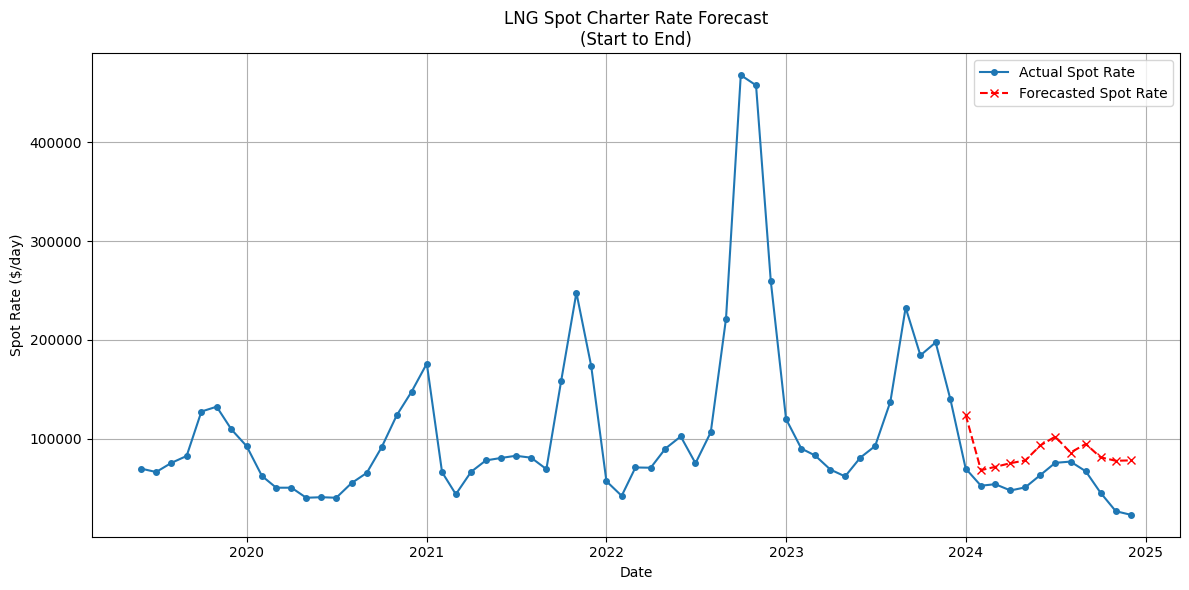

NameError: name 'pd' is not defined

In [9]:
from plotfunction import plot_spot_rates
plot_spot_rates(forecast_export)
plot_spot_rates(forecast_export, start_date='2024-01-01', end_date='2024-12-01')
